In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
import numpy as np
import pandas as pd
import os
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import utilities
from descriptor import rdkitDescriptors

In [2]:
df=pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] =utilities.clean_out_of_bound(df['value (% BOD)'])

In [3]:
features = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'])

In [4]:
smiles_features=pd.concat([df['SMILES'],features], axis=1)

# 1 Divide the feature columns by dtypes (float and int)

# 1.1 int features

In [5]:
feat_int =features.select_dtypes(include=['int64'])

In [6]:
selected_int_feat = feat_int.loc[:,feat_int.nunique()>1]

## 1.2 float features

In [7]:
feat_float = features.select_dtypes(include=['float64'])

In [8]:
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]

# 2 Divide BOD by different cutoff

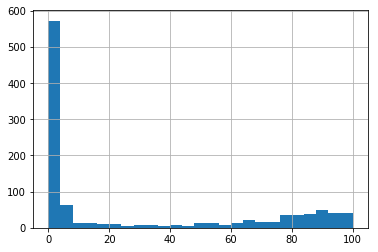

In [37]:
df['cleaned_bod'].hist(bins=25)

## 2.1 50% quantile two classes

In [9]:
df['bi_class_q50']=pd.qcut(df['cleaned_bod'].values, 2, labels=[0,1])
true_label_q50 = df['bi_class_q50'].values

## 2.2 33%, 66% quantile 3 classes (manual implement due to duplicate edges)

In [10]:
tri_cuts=df['cleaned_bod'].quantile([0.33,0.66]).values

In [13]:
df['tri_class_q33']=utilities.divide_classes(df['cleaned_bod'], tri_cuts)

In [14]:
true_label_q33=df['tri_class_q33'].values

(array([413.,   0.,   0.,   0.,   0., 288.,   0.,   0.,   0., 362.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

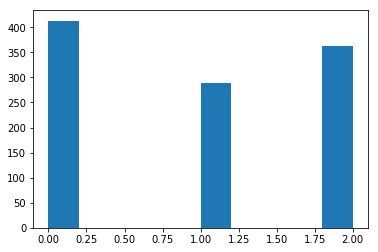

In [69]:
plt.hist(true_label_q33)

## 2.3 25%, 50%, 75% 4 classes (manual)

In [15]:
quart_cuts=df['cleaned_bod'].quantile([0.25,0.50,0.75]).values

In [16]:
len(quart_cuts)

3

In [17]:
df['quart_class_q25']=utilities.divide_classes(df['cleaned_bod'], quart_cuts)

In [19]:
true_label_q25 = df['quart_class_q25'].values

(array([413.,   0.,   0., 122.,   0.,   0., 262.,   0.,   0., 266.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

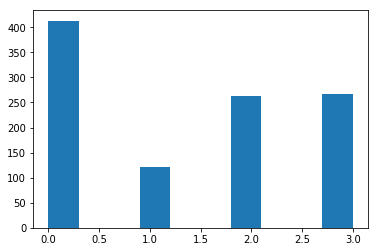

In [71]:
plt.hist(true_label_q25) #inbalanced

## 2.4 Partitioning into three classes (poor, median, good) based on distribution

In [10]:
df['tri_class_partition']=utilities.divide_classes(df['cleaned_bod'], [0.2,0.8])

In [11]:
np.unique(df['tri_class_partition'])

array([0, 1, 2], dtype=int64)

(array([416.,   0.,   0.,   0.,   0.,   9.,   0.,   0.,   0., 638.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

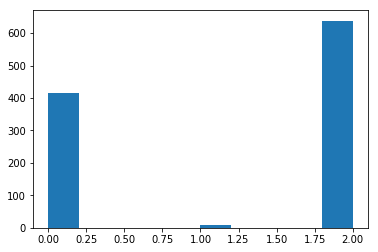

In [12]:
plt.hist(df['tri_class_partition'])

In [13]:
true_label_triclass= df['tri_class_partition'].values

# 3 baseline-kmeans

## 3.1 wrapper function

In [14]:
from sklearn.cluster import KMeans
import sklearn.metrics.cluster as cluster_metric

* No ground true label metrics evaluations packet

In [15]:
def no_label_metrics(input_feature, assigned_label, metric = 'euclidean'):
    print("silhouette score: % s" % cluster_metric.silhouette_score(input_feature, assigned_label, metric=metric))
    print("calinski score: % s" % cluster_metric.calinski_harabaz_score(input_feature, assigned_label))
    print("davie bouldin socre: % s" % cluster_metric.davies_bouldin_score(input_feature, assigned_label))

* metrics with ground true label

In [16]:
def true_label_metrics(true_label, assigned_label):
    print("with True label estimate")
    print("adjusted rand score: % s " % cluster_metric.adjusted_rand_score(true_label, assigned_label))
    print("adjusted mutual info score: % s" % cluster_metric.adjusted_mutual_info_score(true_label, assigned_label)) 
    print("homogeneity completeness v measure:")
    print(cluster_metric.homogeneity_completeness_v_measure(true_label, assigned_label))
    print("fowlkes_mallows : % s" % cluster_metric.fowlkes_mallows_score(true_label, assigned_label))

## 3.2 bi-class 50 quantile cluster

### 3.2.1 int feature

In [38]:
kmeans2_int = KMeans(n_clusters=2, init='k-means++', tol=1e-6).fit(selected_int_feat.values)

In [39]:
label_2_int = kmeans2_int.labels_

In [40]:
no_label_metrics(selected_int_feat.values, label_2_int)

silhouette score: 0.5475756430178326
calinski score: 675.2304536098828


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 1.0107598758571776


In [41]:
true_label_metrics(true_label_q50, label_2_int)

with True label estimate
adjusted rand score: 0.001795278078604992 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: 0.00195655374386627
homogeneity completeness v measure:
(0.002636005876416948, 0.004280409317187768, 0.0032627260792584697)
fowlkes_mallows : 0.6093197129654911


### 3.2.2 float feature

In [42]:
kmeans2_flt = KMeans(n_clusters=2, init='k-means++', tol=1e-6).fit(selected_float_feat.values)
label_2_flt = kmeans2_flt.labels_

In [45]:
no_label_metrics(selected_float_feat.values, label_2_flt)
print('\n')
true_label_metrics(true_label_q50, label_2_flt)

silhouette score: 0.9772412798979195
calinski score: 2449.94638482056


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 0.015276316032467912


with True label estimate
adjusted rand score: -2.4617415490710395e-05 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: -8.89558430810096e-06
homogeneity completeness v measure:
(0.0009324855614722467, 0.08622182815151025, 0.0018450173355687419)
fowlkes_mallows : 0.7061152060370829


## 3.3 tri-class 33 quantile cluster

In [56]:
kmeans3_int = KMeans(n_clusters=3, init='k-means++', tol=1e-6).fit(selected_int_feat.values)
label_3_int = kmeans3_int.labels_

In [61]:
np.unique(label_3_int)

array([0, 1, 2])

In [55]:
kmeans3_flt = KMeans(n_clusters=3, init='k-means++', tol=1e-6).fit(selected_float_feat.values)
label_3_flt = kmeans3_flt.labels_

* int model

In [53]:
no_label_metrics(selected_int_feat.values, label_3_int)
print('\n')
true_label_metrics(true_label_q33, label_3_int)

silhouette score: 0.35080186742740926
calinski score: 552.6131493456152


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 1.2489585174419504


with True label estimate
adjusted rand score: 0.02336454912047083 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: 0.02860238627236767
homogeneity completeness v measure:
(0.03029183491865626, 0.04005681517080529, 0.03449659463196807)
fowlkes_mallows : 0.4305567465820757


* float model

In [54]:
no_label_metrics(selected_float_feat.values, label_3_flt)
print('\n')
true_label_metrics(true_label_q33, label_3_flt)

silhouette score: 0.5145831660737494
calinski score: 2303.9375527723414


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 0.6704360207894599


with True label estimate
adjusted rand score: 0.0047653920165068924 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: 0.004043627139309216
homogeneity completeness v measure:
(0.00584537357235193, 0.01223698843892061, 0.007911551464510112)
fowlkes_mallows : 0.47904337968793276


### not much better compare to the bi-class model

## 3.4 quart-class 25 quantile cluster

In [62]:
kmeans4_int = KMeans(n_clusters=4, init='k-means++', tol=1e-6).fit(selected_int_feat.values)
label_4_int = kmeans3_int.labels_

In [63]:
kmeans4_flt = KMeans(n_clusters=4, init='k-means++', tol=1e-6).fit(selected_float_feat.values)
label_4_flt = kmeans3_flt.labels_

In [64]:
no_label_metrics(selected_int_feat.values, label_4_int)
print('\n')
true_label_metrics(true_label_q25, label_4_int)

silhouette score: 0.35080186742740926
calinski score: 552.6131493456153


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 1.2489585174419497


with True label estimate
adjusted rand score: 0.013679741109771796 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: 0.02186197920595164
homogeneity completeness v measure:
(0.023991557453528368, 0.038131068980921425, 0.02945219108485467)
fowlkes_mallows : 0.39166647916558767


In [66]:
no_label_metrics(selected_float_feat.values, label_4_flt)
print('\n')
true_label_metrics(true_label_q25, label_4_flt)

silhouette score: 0.5145831660737494
calinski score: 2303.9375527723414


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 0.6704360207894599


with True label estimate
adjusted rand score: 0.0005972048303655234 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: 0.003765983785518106
homogeneity completeness v measure:
(0.005784568101130211, 0.014554688662948402, 0.008278826383692282)
fowlkes_mallows : 0.438021219858966


## 3.5 three classes with customed partition

In [17]:
kmeans3_custom_int = KMeans(n_clusters=3, init='k-means++', tol=1e-6).fit(selected_int_feat.values)
label_3_custom_int = kmeans3_custom_int.labels_

In [18]:
kmeans3_custom_float = KMeans(n_clusters=3, init='k-means++', tol=1e-6).fit(selected_float_feat.values)
label_3_custom_float = kmeans3_custom_float.labels_

In [19]:
no_label_metrics(selected_float_feat.values, label_3_custom_float)
print('\n')
true_label_metrics(true_label_triclass, label_3_custom_float)

silhouette score: 0.5145831660737494
calinski score: 2303.9375527723414


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 0.6704360207894599


with True label estimate
adjusted rand score: 0.012905443719928801 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: 0.0008555537750469851
homogeneity completeness v measure:
(0.003215695429681247, 0.004417672802999309, 0.003722050295336909)
fowlkes_mallows : 0.5907397477034864


In [20]:
no_label_metrics(selected_int_feat.values, label_3_custom_int)
print('\n')
true_label_metrics(true_label_triclass, label_3_custom_int)

silhouette score: 0.35080186742740926
calinski score: 552.6131493456152


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


davie bouldin socre: 1.2489585174419504


with True label estimate
adjusted rand score: 0.01891188863541609 


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


adjusted mutual info score: 0.012168884272656782
homogeneity completeness v measure:
(0.016794113814769415, 0.014573514162877376, 0.015605212845990772)
fowlkes_mallows : 0.5209773924568727
